In [1]:
%load_ext autoreload
%autoreload 2

import jax
jax.config.update("jax_enable_x64", True)

import numpyro
numpyro.set_host_device_count(4)

import numpy as np
import scipy.optimize

import ultraplot as uplt

## Read the Data and Look at Interpolation

In [2]:
from des_y6_nz_modeling import read_data

data = read_data("N_gamma_alpha_v1.hdf5", redshift_type="true")

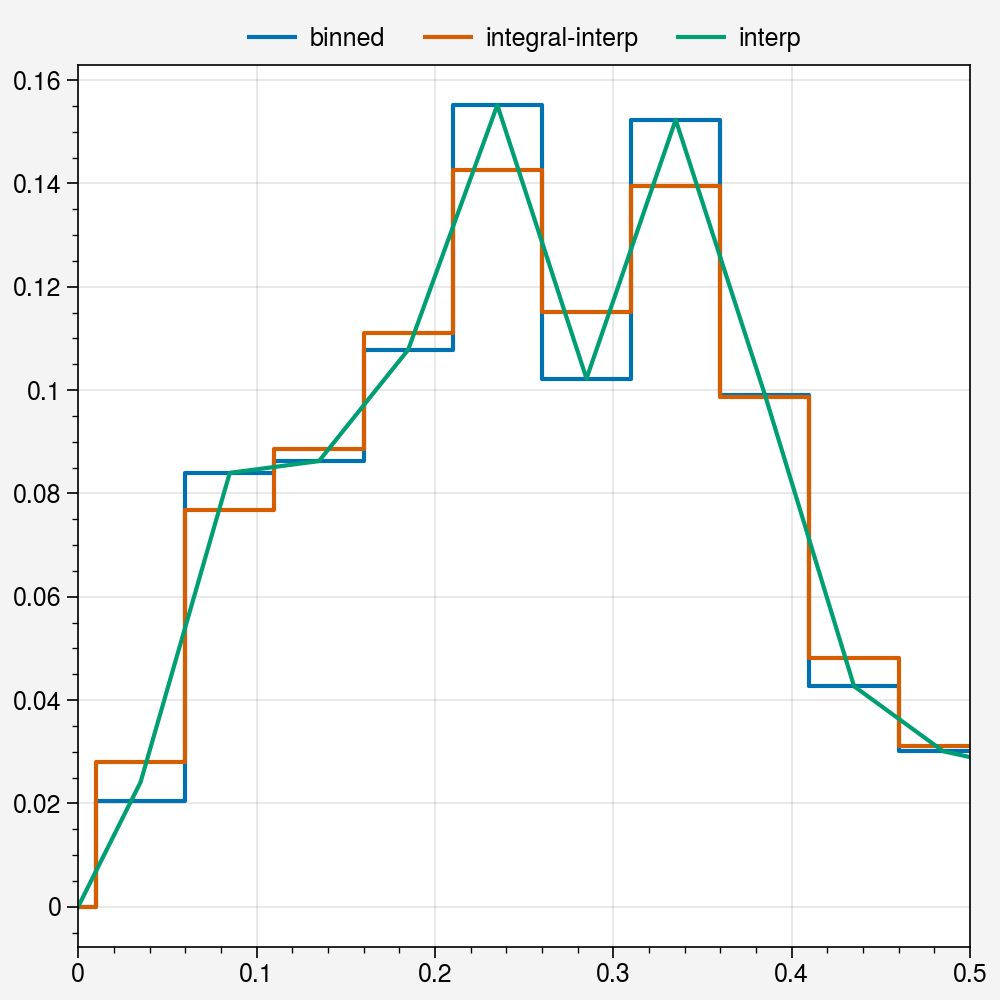

In [3]:
from des_y6_nz_modeling import nz_binned_to_interp, sompz_integral

nz = data.nzs[0]
assert np.allclose(np.sum(nz), sompz_integral(nz, 0, 6))

be = data.z - 0.025
be = np.concatenate([be, [be[-1] + 0.05]])
be[0] = 0.0

nzi = np.zeros_like(nz)
for i in range(nz.shape[0]):
    nzi[i] = sompz_integral(nz, be[i], be[i+1])


zlin, nzlin = nz_binned_to_interp(nz)

fig, axs = uplt.subplots(figsize=(5, 5))

axs.plot([0.035-0.05] + data.z.tolist(), [0] + nz.tolist(), drawstyle="steps-mid", label="binned")
axs.plot([0.035-0.05] + data.z.tolist(), [0] + nzi.tolist(), drawstyle="steps-mid", label="integral-interp")
axs.plot(zlin, nzlin*0.05, label="interp")
axs.legend(loc="t", frameon=False)
axs.format(xlim=(0, 0.5))

## Fit the Data

In [4]:
import numpyro
from numpyro.infer import MCMC, NUTS

In [5]:
import bump

model_module = bump

model_data = model_module.make_model_data(
    z=data.z,
    nzs=data.nzs,
    mn=data.mn,
    cov=data.cov,
    mn_pars=data.mn_pars,
    zbins=data.zbins,
    fixed_param_values={"w": 0.1, "g_b0": 0.0, "g_b1": 0.0, "g_b2": 0.0, "g_b3": 0.0},
    num_bins=9,
)

## MAP

In [6]:
import yaml

from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO, autoguide

guide = autoguide.AutoDelta(model_module.model)
optimizer = numpyro.optim.Adam(0.001)
svi = SVI(model_module.model, guide, optimizer, Trace_ELBO())
svi_results = svi.run(
    random.PRNGKey(42),
    50_000,
    **model_data,
)
map_params = svi_results.params

for key in list(map_params.keys()):
    if key.endswith("_auto_loc"):
        new_key = key[:-len("_auto_loc")]
        map_params[new_key] = map_params[key]
        del map_params[key]

for k, v in (model_data["fixed_param_values"] or {}).items():
    map_params[k] = v
print(yaml.dump({k: float(v) for k,v in map_params.items()}))

100%|██████████| 50000/50000 [00:22<00:00, 2184.93it/s, init loss: 19757.3342, avg. loss [47501-50000]: -123.1717]


a0_b0: -0.13518126672460085
a0_b1: -0.14722049042327257
a0_b2: -0.0420719200053945
a0_b3: -0.06368045410276402
a1_b0: 0.26048458107923445
a1_b1: 0.13799875704355458
a1_b2: -0.275124169594692
a1_b3: 0.32326593672952697
a2_b0: -0.1760852416934604
a2_b1: -0.07415252252980231
a2_b2: 0.2530112658007777
a2_b3: -0.08625941264060444
a3_b0: -0.6753781750109038
a3_b1: 0.14868302577994896
a3_b2: -0.1980100194393426
a3_b3: 0.19045167465376878
a4_b0: 0.06202489554062751
a4_b1: -0.7805456273925042
a4_b2: 0.3436981112511024
a4_b3: -0.2844679053978769
a5_b0: -0.9229767670940188
a5_b1: 0.6934373093822366
a5_b2: -2.4776849649281596
a5_b3: 0.16497309375098723
a6_b0: 0.37619049703280005
a6_b1: -5.968640176495354
a6_b2: 3.791562480054706
a6_b3: -0.7904838803307435
a7_b0: -1.131103935234627
a7_b1: 2.819345047703056
a7_b2: -3.1056060008901696
a7_b3: 0.22768594813187804
a8_b0: 0.22682503809257248
a8_b1: -1.3115351966103557
a8_b2: 0.46472822746077824
a8_b3: -0.898581871834562
g_b0: 0.0
g_b1: 0.0
g_b2: 0.0
g_b3

In [7]:
import scipy.stats

model_mn = model_module.model_mean(
    params=map_params,
    **model_data,
)
dmn = model_mn - data.mn
chi2 = np.dot(dmn, np.dot(np.linalg.inv(model_data["cov"]), dmn.T))
dof = data.mn.shape[0] - len(map_params) + len(model_data["fixed_param_values"] or {})
print("chi2:", chi2)
print("dof:", dof)
print("p-value:", scipy.stats.chi2.sf(chi2, dof))
print("m vals:\n    model: %r\n    data: %r\n     err: %r" % (
    (model_mn[:4]-1).tolist(),
    (data.mn[:4]-1).tolist(),
    (np.sqrt(np.diag(data.cov)[:4])).tolist(),
))

chi2: 3.8000582454879366
dof: 8
p-value: 0.8746972338142673
m vals:
    model: [-0.0059582177238513, 0.014403749366572072, 0.01688626983349928, 0.00967690252106257]
    data: [-0.006994349826206503, 0.016036566228740057, 0.017247239530250313, 0.009428620061380233]
     err: [0.004593226944328782, 0.006142812018330256, 0.005437871858005932, 0.009363355942622971]


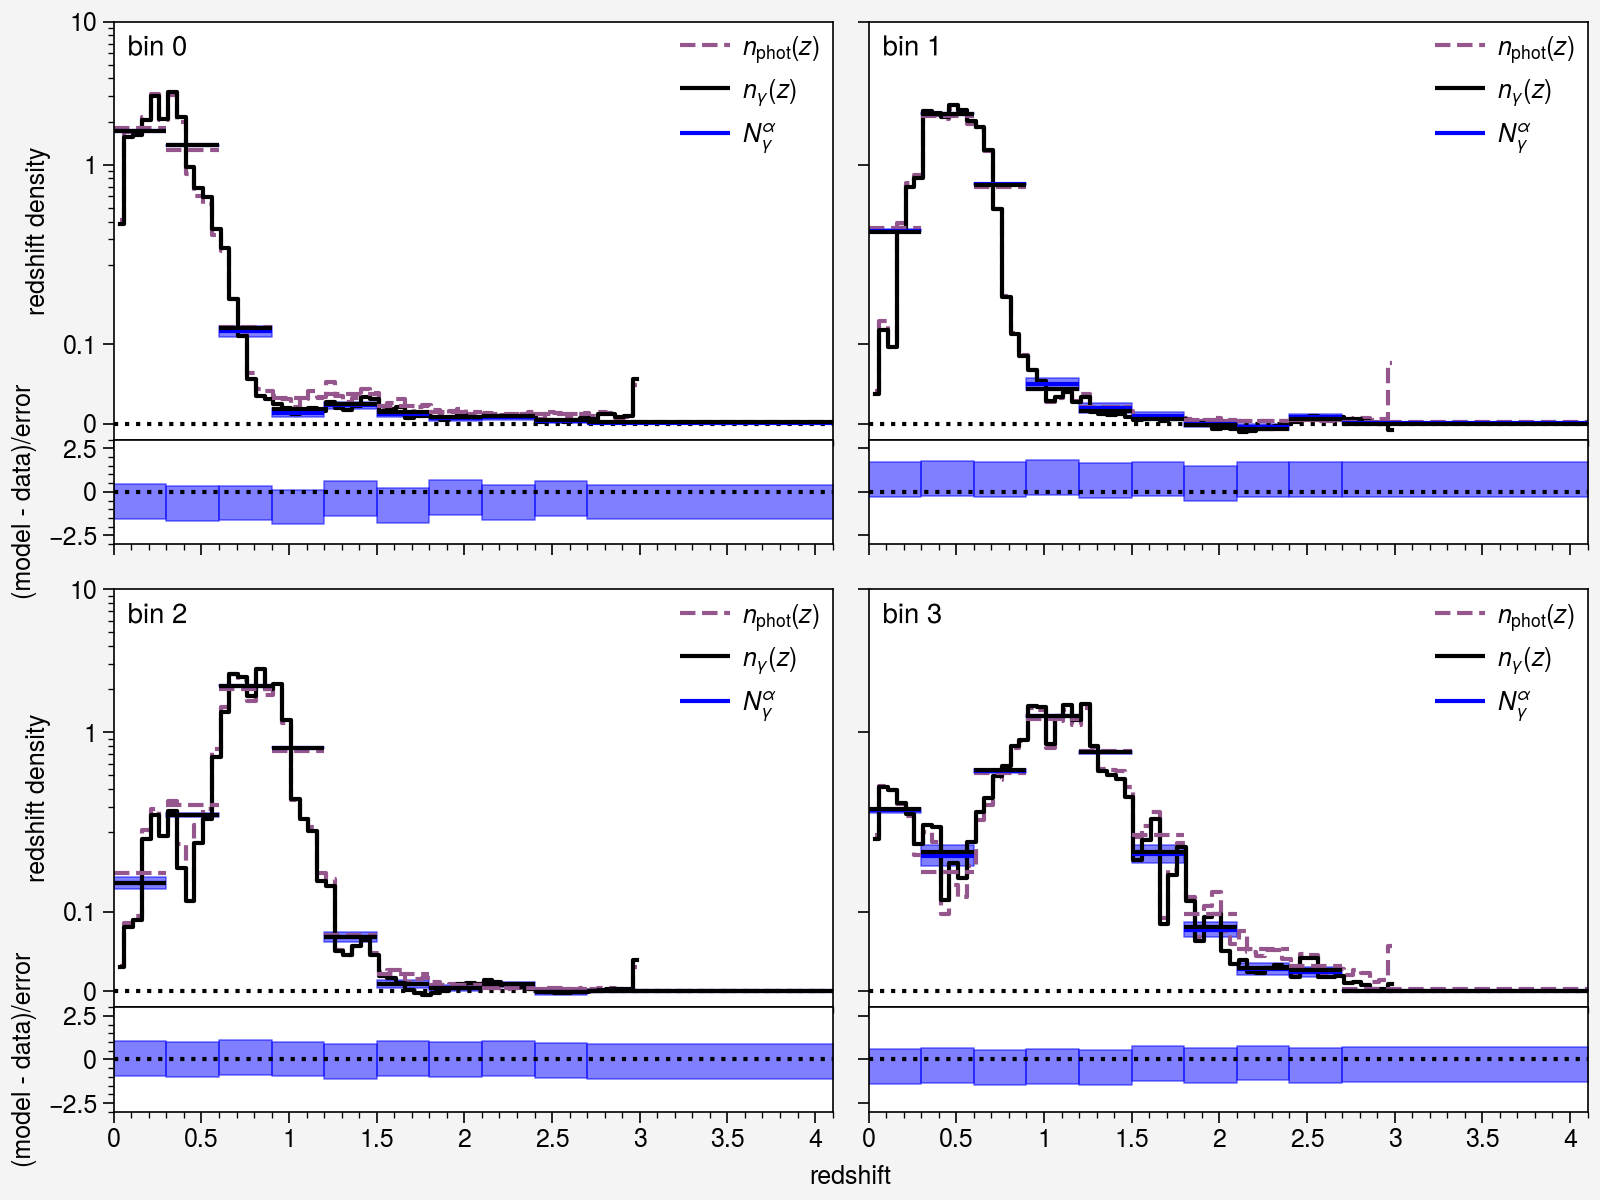

In [8]:
from des_y6_nz_modeling import plot_results

fig = plot_results(model_module=model_module, model_data=model_data, map_params=map_params)

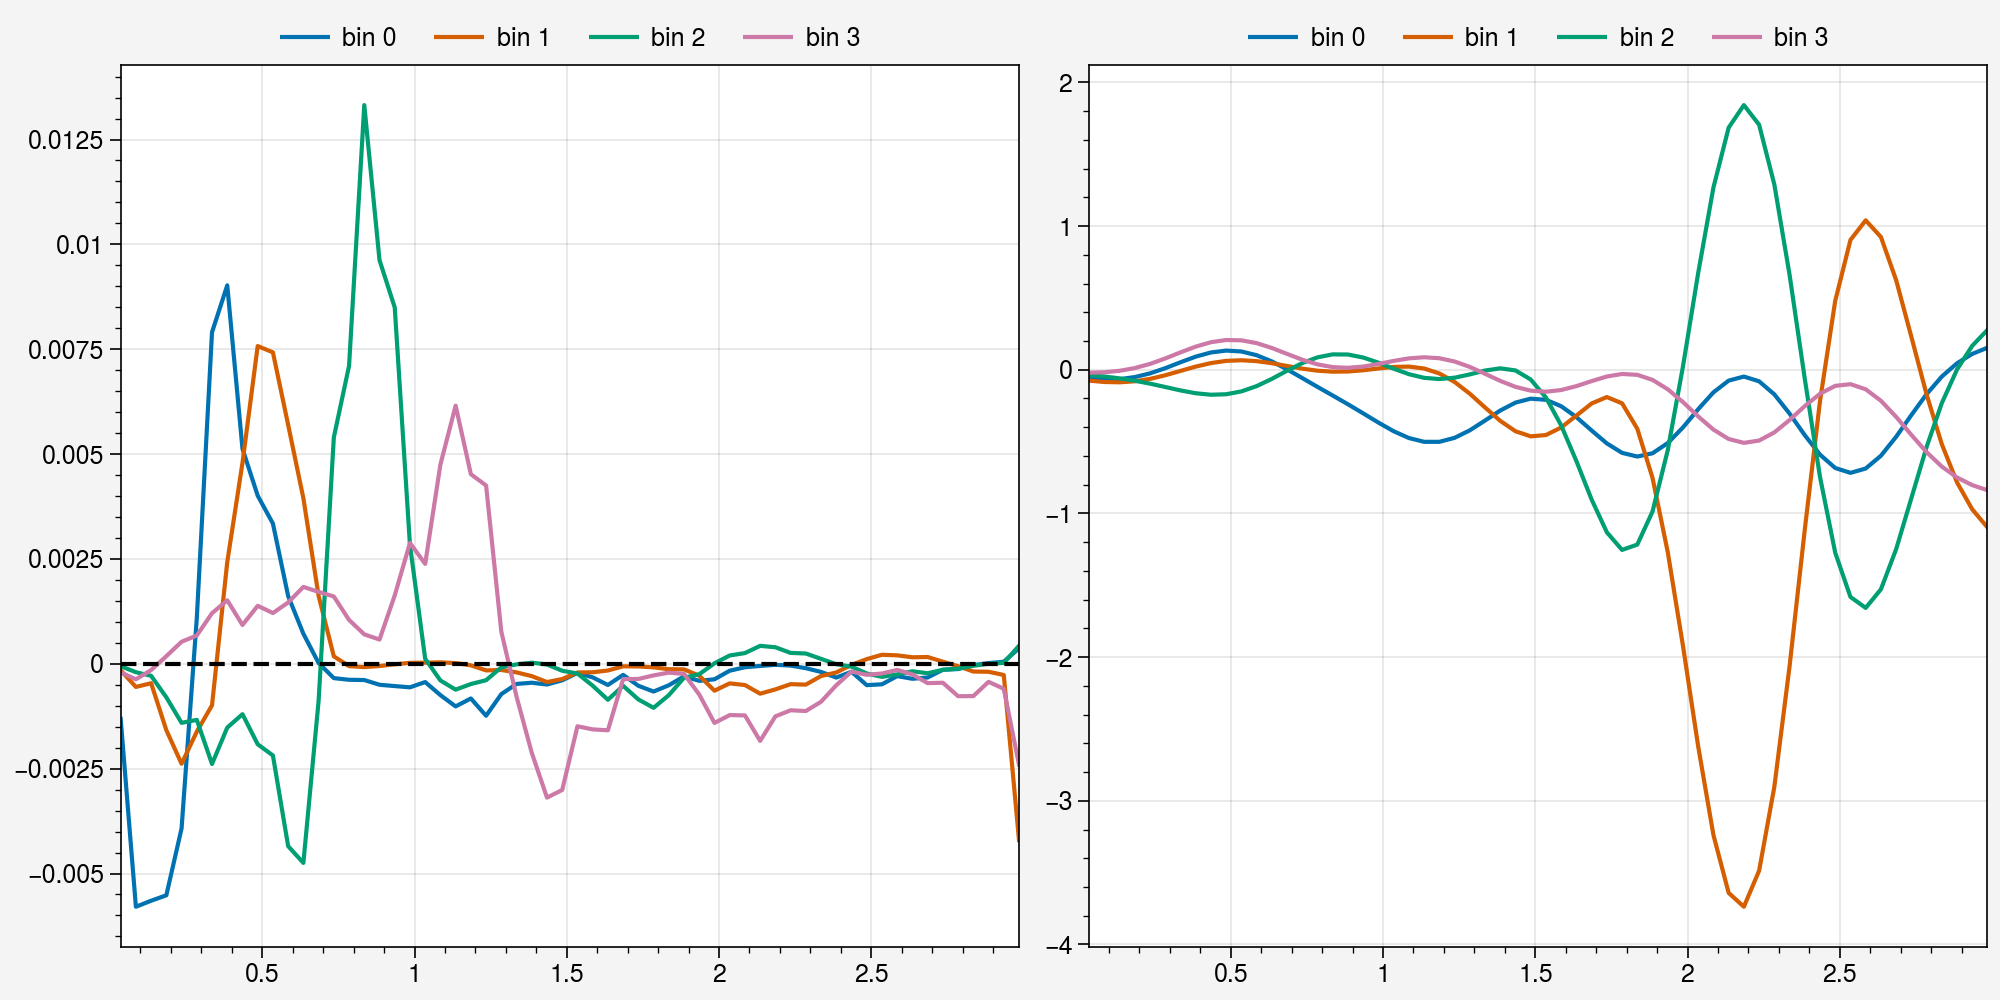

In [9]:
if hasattr(model_module, "model_parts_smooth"):
    model_parts = model_module.model_parts_smooth(
        params=map_params,
        **model_data,
    )

    fig, axs = uplt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=0)
    for i in range(4):
        m = axs[0, 0].plot(data.z, model_parts[i]["F"] * data.nzs[i], label=f"bin {i}")
        # axs[0, 0].plot(data.z, 0.03 * data.nzs[i], color=m[0].get_color(), ls="-.")
        if np.any(model_parts[i]["G"] > 0):
            axs[0, 0].plot(data.z, model_parts[i]["G"], ls="--", color=m[0].get_color())
    axs[0, 0].legend(loc="t", frameon=False, ncols=4)
    axs[0, 0].axhline(0.0, color="k", ls="--")

    for i in range(4):
        m = axs[0,1].plot(data.z, model_parts[i]["F"], label=f"bin {i}")
    axs[0, 1].legend(loc="t", frameon=False, ncols=4)

# MCMC

In [10]:
from jax import random
from numpyro.infer import init_to_sample, init_to_value

rng_key = random.PRNGKey(42)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(
    model_module.model,
    init_strategy=init_to_value(values=map_params),
    max_tree_depth=10,
)
mcmc = MCMC(
    kernel,
    num_warmup=500,
    num_samples=1000,
    num_chains=4,
)
mcmc.run(
    rng_key_,
    **model_data,
)


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [11]:
mcmc.print_summary(exclude_deterministic=False)
samples = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0     -0.14      0.01     -0.14     -0.15     -0.12   4231.74      1.00
     a0_b1     -0.15      0.04     -0.15     -0.22     -0.07   3642.78      1.00
     a0_b2     -0.04      0.08     -0.04     -0.18      0.09   2764.52      1.00
     a0_b3     -0.06      0.08     -0.06     -0.19      0.06   2905.69      1.00
     a1_b0      0.26      0.03      0.26      0.22      0.30   3657.16      1.00
     a1_b1      0.14      0.03      0.14      0.09      0.19   3111.03      1.00
     a1_b2     -0.28      0.07     -0.28     -0.39     -0.16   2136.04      1.00
     a1_b3      0.32      0.15      0.32      0.06      0.57   1780.27      1.00
     a2_b0     -0.18      0.12     -0.18     -0.37      0.02   3268.97      1.00
     a2_b1     -0.07      0.07     -0.07     -0.18      0.03   2611.14      1.00
     a2_b2      0.25      0.05      0.25      0.18      0.33   2097.36      1.00
     a2_b3     -0.08      0

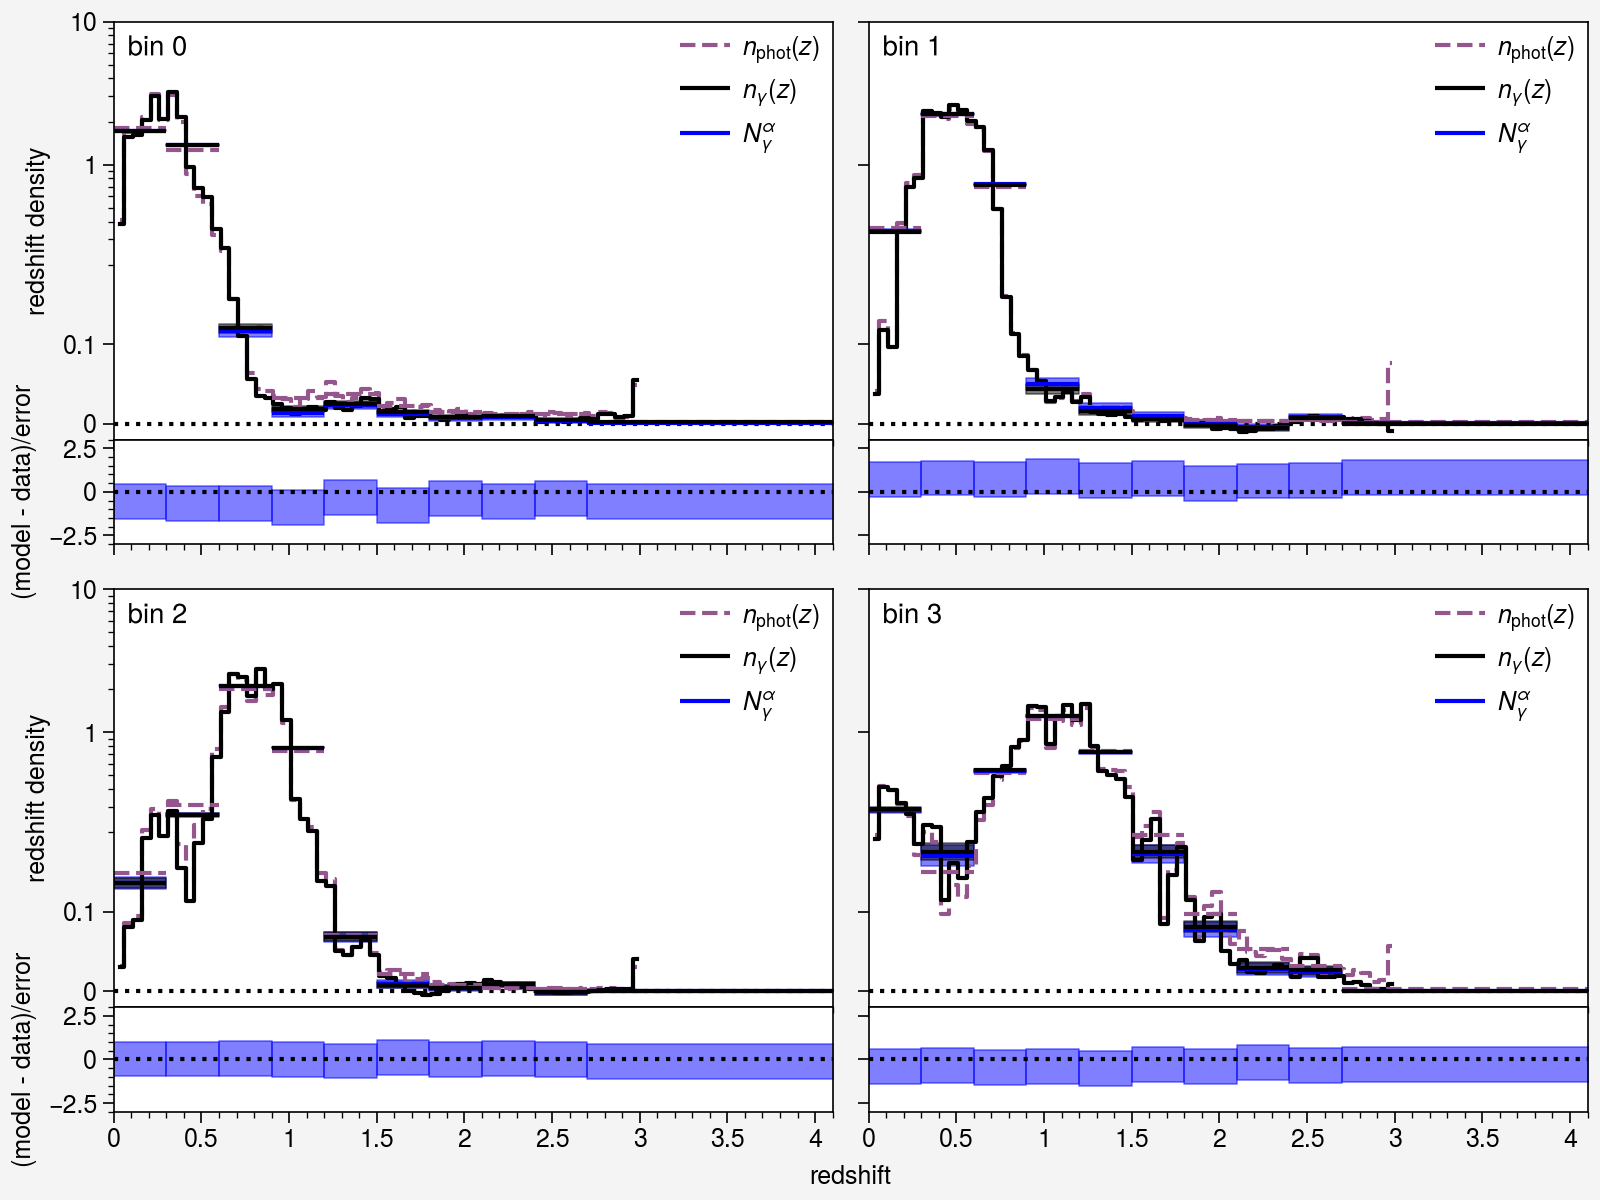

In [12]:
from des_y6_nz_modeling import plot_results

fig = plot_results(model_module=model_module, model_data=model_data, samples=samples)
# fig.savefig("fgfit.pdf")
# fig.savefig("fgfit.png", dpi=600)

In [13]:
from des_y6_nz_modeling import measure_m_dz

mz_data = measure_m_dz(model_module=model_module, model_data=model_data, samples=samples, return_dict=False)

In [14]:
m_mn = mz_data.mean(axis=0)[[0, 2, 4, 6]]
m_sd = mz_data.std(axis=0, ddof=1)[[0, 2, 4, 6]]

dz_mn = mz_data.mean(axis=0)[[1, 3, 5, 7]]
dz_sd = mz_data.std(axis=0, ddof=1)[[1, 3, 5, 7]]

In [15]:
print("|--------------------------------------------|")
print("| bin | m [10^-3, 3sigma] | dz               |")
print("|--------------------------------------------|")
for i in range(4):
    print(
        "| %d   | %+5.1f +/- %-5.1f   | %+0.3f +/- %0.3f |" % (
            i, m_mn[i]/1e-3, m_sd[i]/1e-3 * 3, dz_mn[i], dz_sd[i]
        )
    )
print("|--------------------------------------------|")

|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz               |
|--------------------------------------------|
| 0   |  -5.9 +/- 13.5    | -0.013 +/- 0.004 |
| 1   | +14.1 +/- 17.9    | -0.018 +/- 0.005 |
| 2   | +17.0 +/- 15.2    | +0.005 +/- 0.004 |
| 3   |  +9.8 +/- 27.2    | -0.037 +/- 0.008 |
|--------------------------------------------|
